<a href="https://colab.research.google.com/github/m3sibti/DL_projects/blob/master/Keras_ConditionalGAN_mw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GANs

## Imports

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

## Prepare MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train.shape, np.min(x_train), np.max(x_train), y_train.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), 0.0, 1.0, (60000, 10))

## Create Models

### Generator

In [0]:
def get_generator(z_shape, l_shape):
  z_input = keras.Input(shape=(z_shape,))
  label_input = keras.Input(shape=(l_shape,))
  x = layers.Concatenate()([z_input, label_input])
  x = layers.Dense(256, activation='relu')(x)
  output = layers.Dense(784, activation='sigmoid')(x)
  
  model = keras.Model([z_input, label_input], output)
  return model 

In [0]:
generator = get_generator(100, 10)

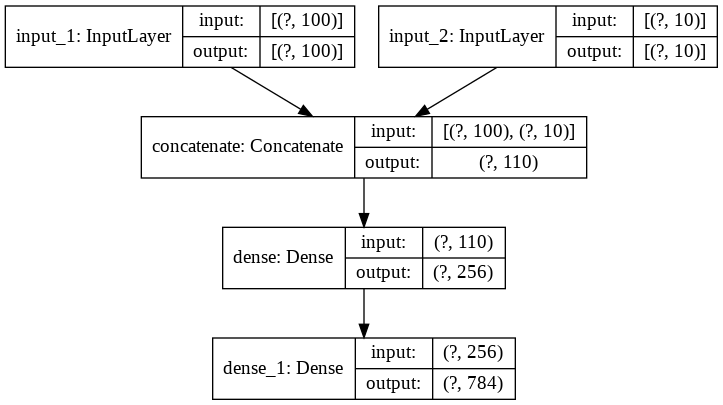

In [5]:
keras.utils.plot_model(generator, show_shapes=True)

### Discriminator

In [0]:
def get_discriminator(i_shape, l_shape):
  img_input = keras.Input(shape=(i_shape,))
  label_input = keras.Input(shape=(l_shape,))
  x = layers.Concatenate()([img_input, label_input])
  x = layers.Dense(256, activation=tf.nn.leaky_relu)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model([img_input, label_input], outputs)
  return model

In [0]:
discriminator = get_discriminator(784, 10)

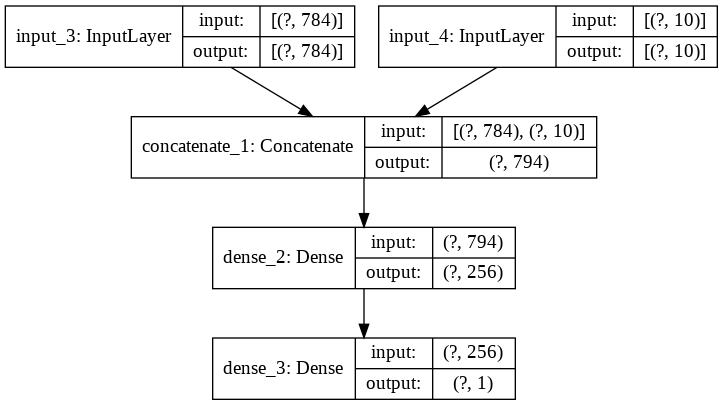

In [8]:
keras.utils.plot_model(discriminator, show_shapes=True)

## Override the train_step

In [0]:
class CGAN(keras.Model):

  def __init__(self, disc, gen, l_dim, n_labels):
    super(CGAN, self).__init__()
    self.discriminator = disc
    self.generator = gen
    self.latent_dim = l_dim
    self.n_classes = n_labels

  def compile(self, d_opt, g_opt, loss_fn):
    super(CGAN, self).compile()
    self.d_opt = d_opt
    self.g_opt = g_opt
    self.loss_fn = loss_fn

  def train_step(self, data):
    real_images, real_labels = data
    bs = tf.shape(real_images)[0]

    random_vector = tf.random.normal(shape=(bs, self.latent_dim))
    random_labels = tf.random.normal(shape=(bs, self.n_classes))

    generated_imgs = self.generator([random_vector, random_labels])

    combined_images = tf.concat([generated_imgs, real_images], axis=0)
    combined_labels = tf.concat([random_labels, real_labels], axis=0)
    y_hats = tf.concat([tf.zeros((bs, 1)), tf.ones((bs, 1))], axis=0)

    with tf.GradientTape() as tape:
      preds = self.discriminator([combined_images, combined_labels])
      loss = self.loss_fn(y_hats, preds)
    grads = tape.gradient(loss, self.discriminator.trainable_weights)
    self.d_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))


    # Generators Turn
    random_vector = tf.random.normal(shape=(bs, self.latent_dim))
    random_labels = tf.random.normal(shape=(bs, self.n_classes))
    misleading_labels = tf.ones((bs, 1))

    with tf.GradientTape() as tape:
      g_preds = self.discriminator([self.generator([random_vector, random_labels]), random_labels])
      g_loss = self.loss_fn(misleading_labels, g_preds)

    g_grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_weights))

    return {"d_loss": loss, "g_loss":g_loss}



## Callback

In [0]:
class GANMonitor(keras.callbacks.Callback):
  
  def __init__(self, num_images=25, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_vector = tf.random.normal(shape=(self.num_images, self.latent_dim))
    random_labels = tf.random.normal(shape=(self.num_images, 10))
    generated_imgs = self.model.generator([random_vector, random_labels])
    generated_imgs *= 255
    # for vanilla gan
    generated_imgs.numpy()
    generated_imgs = np.reshape(generated_imgs, (self.num_images, 28, 28))
    
    
    r, c = 5, 5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(generated_imgs[cnt, :,:], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    os.makedirs('images', exist_ok=True)
    fig.savefig("images/%d.png" % epoch)
    plt.close()
    # for i in range(self.num_images):
      # img = image.array_to_img(generated_imgs[i])
      # img.save(f'gen_imgs/generated_img_{i}_{epoch}.png')
      # img.save(f'generated_img_{i}_{epoch}.png')

        

## Train Model


In [0]:
epochs = 30
latent_dim = 100
n_labels = 10

In [0]:
gan = CGAN(discriminator, generator, latent_dim, n_labels)

In [0]:
gan.compile(
    d_opt = keras.optimizers.Adam(learning_rate=3e-4),
    g_opt = keras.optimizers.Adam(learning_rate=3e-4),
    loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

)

In [0]:
x_train = x_train.reshape(-1, 28*28)

In [53]:
y_train.shape

(60000, 10)

In [54]:
gan.fit(x_train, y_train, epochs=epochs,
        verbose=True,
        callbacks=[GANMonitor()])

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.5109 - g_loss: 0.6898
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.5182 - g_loss: 0.6863
Epoch 3/30
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.5123 - g_loss: 0.6883
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.5097 - g_loss: 0.6896
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.5075 - g_loss: 0.6906
Epoch 6/30
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.5076 - g_loss: 0.6905
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.5048 - g_loss: 0.6920
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.5058 - g_loss: 0.6916
Epoch 9/30
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.5053 - g_loss: 0.6916
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.5

## Display Image

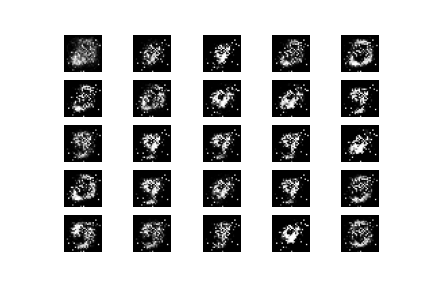

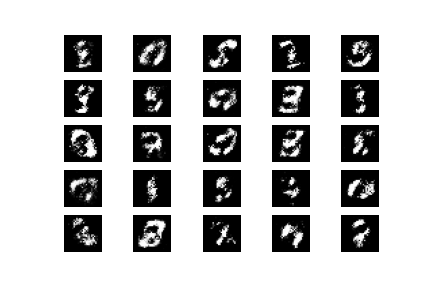

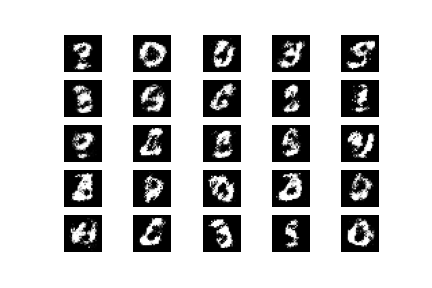

In [56]:
from IPython.display import Image, display

display(Image("images/0.png"))
display(Image("images/15.png"))
display(Image("images/29.png"))